### Modeling 

#### Setup
(Only general setup, model specific imports are done within sections for the models)

In [1]:
# General
import pandas as pd

# Visualisations
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

# nltk.download([
#         "stopwords",
#         "wordnet",
#         "vader_lexicon",
#         "punkt",
#         "punkt_tab",
#     ])



#### Read data

In [3]:
df = pd.read_csv('../../data/cleaned/Apple_Inc_text_data.csv')

# format datetime again
df['pub_date'] = pd.to_datetime(df['pub_date']) 
df['pub_date'] = df['pub_date'].dt.date

#### Text preprocessing/visualisation

* Purely for visualisation, not necessary for VADER/transformer models

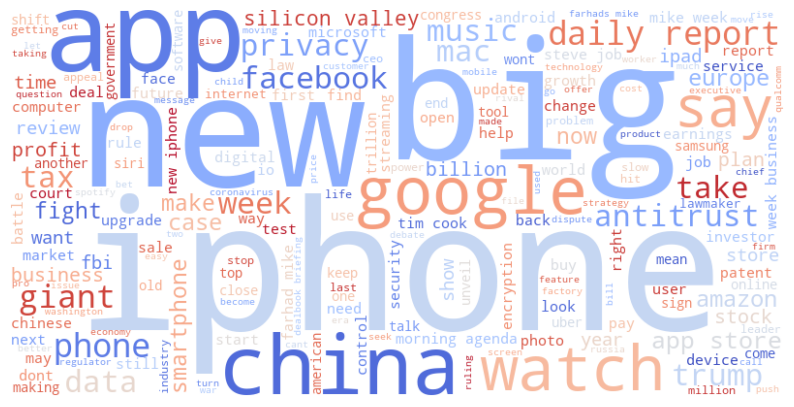

In [3]:
# Function to clean and preprocess text
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove non-alphabetic characters (numbers, punctuation, etc.)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Remove custom stopwords
custom_stopwords = STOPWORDS.union({"apple", "apple's", "the", "and", "is", "to", "in", "of", "for", "on", "with","tech","company","will","said"})

# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Tokenization and stopword removal
def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords and len(word) > 2]  # Lemmatize and remove stopwords & short words
    return ' '.join(tokens)

# Combine all headlines into a single string after cleaning and preprocessing
headlines = ' '.join(df['headline'].apply(lambda x: preprocess_text(clean_text(x))))

# Generate word cloud
wordcloud = WordCloud(stopwords=custom_stopwords, 
                      width=800, height=400, 
                      background_color='white', 
                      max_words=200, 
                      colormap='coolwarm').generate(headlines)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

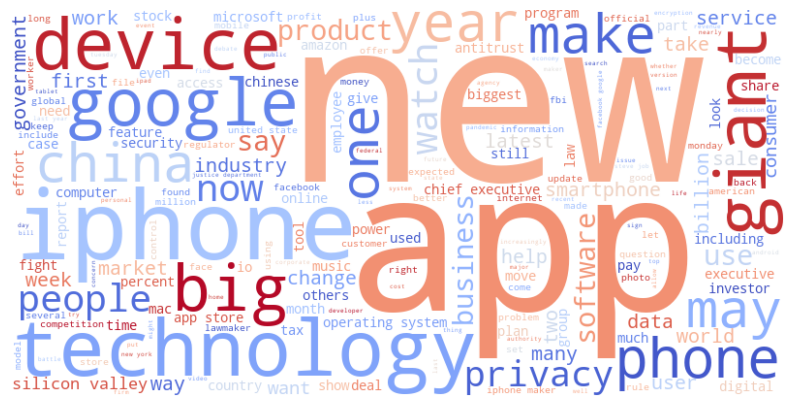

In [4]:
#word cloud for abstract
# Combine all headlines into a single string after cleaning and preprocessing
abstract = ' '.join(df['abstract'].apply(lambda x: preprocess_text(clean_text(x))))

# Generate word cloud
wordcloud = WordCloud(stopwords=custom_stopwords, 
                      width=800, height=400, 
                      background_color='white', 
                      max_words=200, 
                      colormap='coolwarm').generate(abstract)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

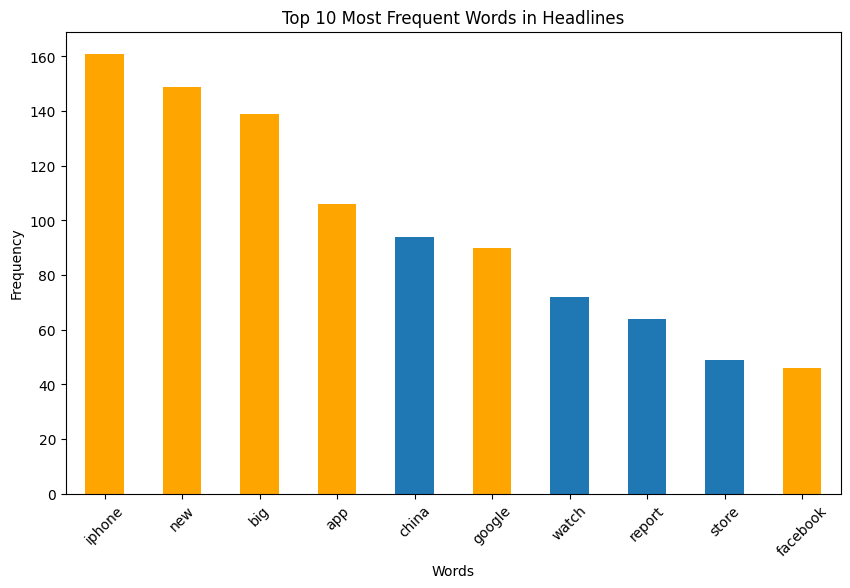

In [5]:
# Select common words to be highlighted
common_words=['new', 'facebook', 'google', 'iphone', 'big', 'app']

# Define custom stopwords to include "Apple" and "tech"
custom_stopwords = stopwords.words('english') + ['apple', 'tech', 'Apple', 'Tech','daily', 'week','company','companies','could','said','says','would']

# Initialize CountVectorizer with stopwords removal
vectorizer = CountVectorizer(stop_words=custom_stopwords)

# Create a bag of words (word frequency matrix)
X = vectorizer.fit_transform(df['headline'])

# Convert to DataFrame for easy handling
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Sum up the word frequencies across all documents (headlines)
word_counts = word_freq.sum(axis=0).sort_values(ascending=False)

# Select top N words (e.g., top 10)
top_n = 10
top_words = word_counts.head(top_n)


# Set colors: Highlight words that appear in the common_words list
colors = ['orange' if word in common_words else '#1f77b4' for word in top_words.index]

# Plotting the bar chart for top words with highlighted common words
plt.figure(figsize=(10, 6))
top_words.plot(kind='bar', color=colors)
plt.title('Top 10 Most Frequent Words in Headlines')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

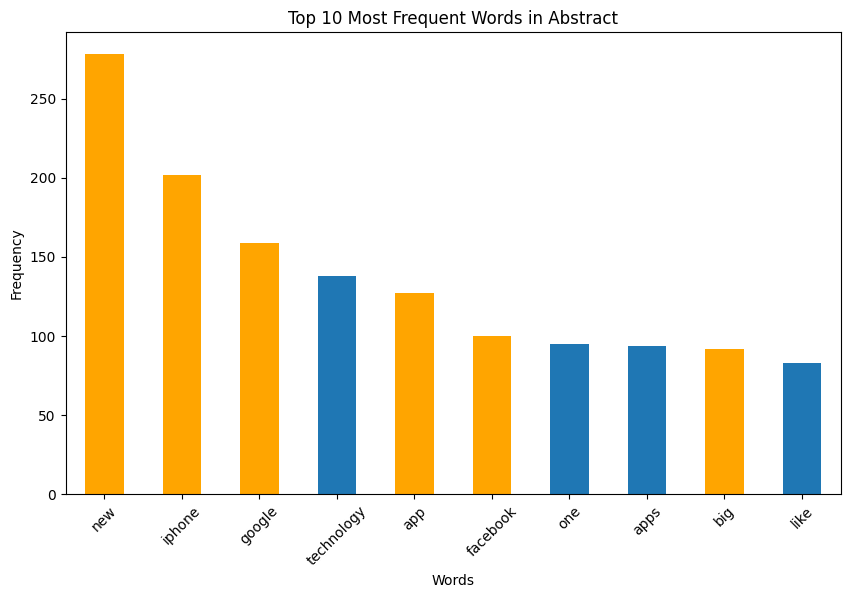

In [6]:
# First, extract the top words from your previous frequency chart (headlines)
top_words_headlines = word_counts.head(top_n).index

# Create a bag of words (word frequency matrix) for the abstract
X = vectorizer.fit_transform(df['abstract'])

# Convert to DataFrame for easy handling
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Sum up the word frequencies across all documents (abstracts)
word_counts_abstract = word_freq.sum(axis=0).sort_values(ascending=False)

# Select top N words (e.g., top 10)
top_words_abstract = word_counts_abstract.head(top_n)

# Plotting the bar chart
plt.figure(figsize=(10, 6))

# Set colors: Highlight words that appear in either top_words_list or top_words_abs_list
colors = ['orange' if word in common_words else '#1f77b4' 
          for word in top_words_abstract.index]

# Plot the bar chart for the abstract's top words
top_words_abstract.plot(kind='bar', color=colors)

# Add title and labels
plt.title('Top 10 Most Frequent Words in Abstract')
plt.xlabel('Words')
plt.ylabel('Frequency')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()


####  Sentiment Analysis (VADER, distillRoBERTa, deBERTa)

Currently, use the Headline.

In the future, can consider:
1. Headline
2. Abstract
3. Lead para
4. Headline + Abstract (and weightage of each)
5. Headline + Lead para (and weightage of each)

In [6]:
sentiment_df=df.copy() #save the df first 
df.head()

,pub_date,abstract,lead_para,headline,doc_type,section_name,type_of_material,rank,web_url
0,2015-04-07,"Want to work at Amazon, Apple or McKinsey? Som...","With some 13,000 graduate schools of business ...",M.B.A. Programs That Get You Where You Want to Go,article,Education,News,7,https://www.nytimes.com/2015/04/12/education/e...
1,2015-04-14,Get recommendations from New York Times report...,Get recommendations from New York Times report...,What We’re Reading,article,Blogs,News,13,https://news.blogs.nytimes.com/2015/04/14/what...
2,2015-04-13,The business unit will partner with companies ...,IBM is taking its Watson artificial-intelligen...,IBM Creates Watson Health to Analyze Medical Data,article,Technology,News,8,https://bits.blogs.nytimes.com/2015/04/13/ibm-...
3,2015-04-22,"With superstars first in line, Apple appears t...","Two weeks ago, Pharrell Williams posted an Ins...",What’s That on Beyoncé’s Wrist? Let Me Guess ....,article,Style,News,1,https://www.nytimes.com/2015/04/23/style/whats...
4,2015-04-01,"In an industry that avoids controversy, the he...",The technology industry’s leaders have found t...,Daily Report: Tech Leaders Come Together to Op...,article,Technology,News,3,https://bits.blogs.nytimes.com/2015/04/01/dail...


##### VADER

In [7]:
# nltk imports
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/trinatan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# Run model
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    # should not have any missing text anymore
    # if pd.isna(text):  # Handle NaN values
    #     return 0  # Neutral score for missing text
    return sia.polarity_scores(text)['compound']

x = sentiment_df['headline'].apply(get_sentiment)
# y = sentiment_df['abstract'].apply(get_sentiment)
# sentiment_df['vader_sent'] = (x+y)/2
sentiment_df['vader_sent']= x

def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

sentiment_df['vader_label'] = sentiment_df['vader_sent'].apply(classify_sentiment)
sentiment_df.head(5)



,pub_date,abstract,lead_para,headline,doc_type,section_name,type_of_material,rank,web_url,vader_sent,vader_label
0,2015-04-07,"Want to work at Amazon, Apple or McKinsey? Som...","With some 13,000 graduate schools of business ...",M.B.A. Programs That Get You Where You Want to Go,article,Education,News,7,https://www.nytimes.com/2015/04/12/education/e...,0.0772,Positive
1,2015-04-14,Get recommendations from New York Times report...,Get recommendations from New York Times report...,What We’re Reading,article,Blogs,News,13,https://news.blogs.nytimes.com/2015/04/14/what...,0.0000,Neutral
2,2015-04-13,The business unit will partner with companies ...,IBM is taking its Watson artificial-intelligen...,IBM Creates Watson Health to Analyze Medical Data,article,Technology,News,8,https://bits.blogs.nytimes.com/2015/04/13/ibm-...,0.2732,Positive
3,2015-04-22,"With superstars first in line, Apple appears t...","Two weeks ago, Pharrell Williams posted an Ins...",What’s That on Beyoncé’s Wrist? Let Me Guess ....,article,Style,News,1,https://www.nytimes.com/2015/04/23/style/whats...,0.0000,Neutral
4,2015-04-01,"In an industry that avoids controversy, the he...",The technology industry’s leaders have found t...,Daily Report: Tech Leaders Come Together to Op...,article,Technology,News,3,https://bits.blogs.nytimes.com/2015/04/01/dail...,0.0000,Neutral


/var/folders/0f/_9krm_xj6v3fx4gv1vgm01mw0000gn/T/ipykernel_3643/1864961287.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=custom_palette)


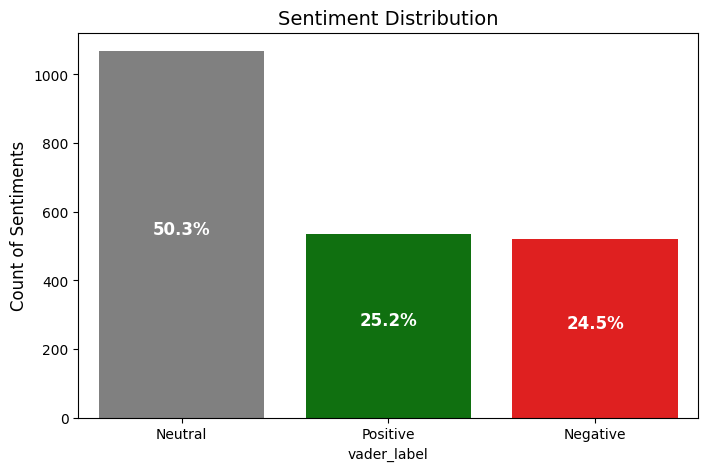

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def sen_bar_plot(df, sentiment_column):
    sentiment_counts = df[sentiment_column].value_counts()

    # Ensure that sentiment counts are ordered according to the specified sentiment_order
    sentiment_order = ['Neutral', 'Positive', 'Negative']
    
    # Reorder sentiment counts according to the custom order
    sentiment_counts = sentiment_counts[sentiment_order]
    
    total = sentiment_counts.sum()
    sentiment_percentages = (sentiment_counts / total) * 100  # Convert to percentages
    
    # Custom color palette
    custom_palette = {'Positive': 'green', 'Negative': 'red', 'Neutral': 'grey'}
    
    # Create the plot
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=custom_palette)
    
    # Annotate bars with percentage values
    for i, (count, percentage) in enumerate(zip(sentiment_counts.values, sentiment_percentages.values)):
        ax.text(i, count * 0.5 , f"{percentage:.1f}%", ha='center', fontsize=12, color='white', weight='bold')

    plt.ylabel('Count of Sentiments', fontsize=12)
    plt.title('Sentiment Distribution', fontsize=14)
    plt.show()


sen_bar_plot(sentiment_df,'vader_label')

##### Transformer (distilRoBERTa - tuned for financial news sentiment)

https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis/tree/main

In [12]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax
import tensorflow as tf

#Load the pre-trained model
MODEL = f"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [13]:
# Predict
def drob_polarity_scores(sentence):
    encoded_text = tokenizer(sentence, return_tensors='tf')
    
    output = model(encoded_text)
    scores = output.logits[0].numpy()
    scores = tf.nn.softmax(scores).numpy()
    
    # scores_dict = {
    #     'drob_neg': scores[0],
    #     'drob_neu': scores[1],
    #     'drob_pos': scores[2]
    # }
    return scores[0], scores[1], scores[2]

sentiment_df[['drob_neg','drob_neu','drob_pos']] = sentiment_df['headline'].apply(drob_polarity_scores).apply(pd.Series)

# Add label based on largest (neg/neu/pos)
sentiment_df['drob_label'] = sentiment_df.apply(lambda x:'Negative' if x['drob_neg'] >
                     x['drob_neu'] and x['drob_neu'] > x['drob_pos'] else ('Neutral' if x['drob_neu']>x['drob_pos'] else 'Positive'),axis=1)

sentiment_df.head()

,pub_date,abstract,lead_para,headline,doc_type,section_name,type_of_material,rank,web_url,vader_sent,vader_label,deb_sentiment,drob_neg,drob_neu,drob_pos,drob_label
0,2015-04-07,"Want to work at Amazon, Apple or McKinsey? Som...","With some 13,000 graduate schools of business ...",M.B.A. Programs That Get You Where You Want to Go,article,Education,News,7,https://www.nytimes.com/2015/04/12/education/e...,0.0772,Positive,Positive,0.000063,0.999864,0.000073,Neutral
1,2015-04-14,Get recommendations from New York Times report...,Get recommendations from New York Times report...,What We’re Reading,article,Blogs,News,13,https://news.blogs.nytimes.com/2015/04/14/what...,0.0000,Neutral,Neutral,0.000071,0.999868,0.000061,Neutral
2,2015-04-13,The business unit will partner with companies ...,IBM is taking its Watson artificial-intelligen...,IBM Creates Watson Health to Analyze Medical Data,article,Technology,News,8,https://bits.blogs.nytimes.com/2015/04/13/ibm-...,0.2732,Positive,Neutral,0.000064,0.999882,0.000054,Neutral
3,2015-04-22,"With superstars first in line, Apple appears t...","Two weeks ago, Pharrell Williams posted an Ins...",What’s That on Beyoncé’s Wrist? Let Me Guess ....,article,Style,News,1,https://www.nytimes.com/2015/04/23/style/whats...,0.0000,Neutral,Neutral,0.000072,0.999858,0.000070,Neutral
4,2015-04-01,"In an industry that avoids controversy, the he...",The technology industry’s leaders have found t...,Daily Report: Tech Leaders Come Together to Op...,article,Technology,News,3,https://bits.blogs.nytimes.com/2015/04/01/dail...,0.0000,Neutral,Negative,0.000267,0.999467,0.000267,Neutral


/var/folders/0f/_9krm_xj6v3fx4gv1vgm01mw0000gn/T/ipykernel_3643/1864961287.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=custom_palette)


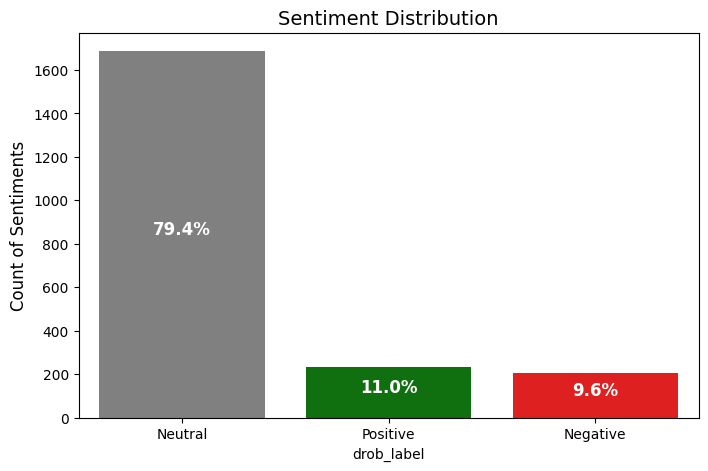

In [14]:
sen_bar_plot(sentiment_df,'drob_label')

##### Transformer (DeBERTa)

In [ ]:
# Load model directly
# Note: need to pip install tiktoken, sentencepiece and restart kernel

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
model = AutoModelForSequenceClassification.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

/opt/anaconda3/envs/MLApps/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/MLApps/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [10]:
import torch

def get_sentiment(headline):
    # Tokenize the input headline
    encoded_text = tokenizer(headline, return_tensors='pt', padding=True, truncation=True)
    
    # Get the model's output (logits)
    output = model(**encoded_text)
    
    # Apply softmax to get probabilities for each class

    probs = torch.nn.functional.softmax(output.logits, dim=-1)
    
    # Extract sentiment scores (negative, neutral, positive)
    deb_neg, deb_neu, deb_pos = probs[0].detach().numpy()
    
    # Assign label based on the highest score
    if deb_neg > deb_neu and deb_neg > deb_pos:
        return 'Negative'
    elif deb_neu > deb_pos:
        return 'Neutral'
    else:
        return 'Positive'

sentiment_df['deb_sentiment'] = sentiment_df['headline'].apply(get_sentiment)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


/var/folders/0f/_9krm_xj6v3fx4gv1vgm01mw0000gn/T/ipykernel_3643/1864961287.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=custom_palette)


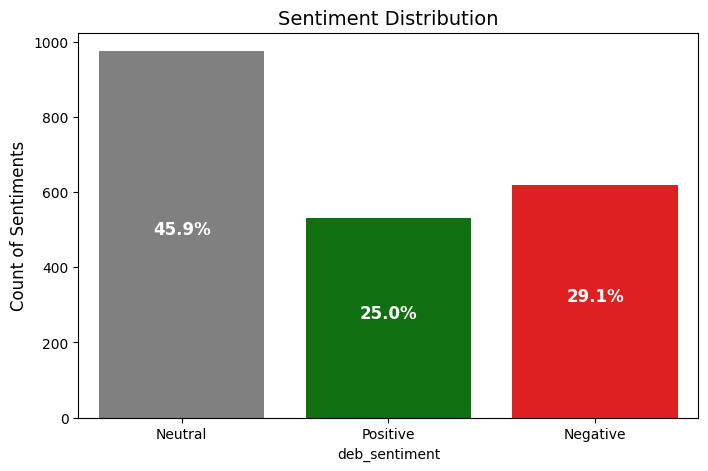

In [11]:
# Step 3: Call the function to plot the sentiment distribution
sen_bar_plot(sentiment_df, 'deb_sentiment')

#### LLM: Gemini
nerfed by api limit

In [128]:
!pip install -U -q "google-genai"

In [ ]:
# Necessary packages
import os
from google import genai
# client = genai.Client(api_key='')

In [ ]:
test = sentiment_df[['headline']].tail(10)
test.head()


,headline
2114,Tim Cook Dines With Trump at Mar-a-Lago
2115,Apple Sued for Failing to Curtail Child Sexual Abuse Material on iCloud
2116,The Great Capitulation
2117,"The Messy Modern Music Business, According to Larry Jackson"
2118,How to Find Your Way Around That Updated Photos App


In [190]:
import google.genai as genai
import pandas as pd
import time
# Initialize the client
client = genai.Client()

# Function to get sentiment based on model output
def gemini_predict(prompt):
    # Generate content from the model
    response = client.models.generate_content(
        model='gemini-2.0-flash', 
        contents=prompt
    )
    
    # Assuming the model output is a sentiment label (e.g., Positive, Negative)
    # You may need to adjust based on the actual format of the response
    sentiment = response.text.strip()
    
    # Return the sentiment label, default to 'Neutral' if the model is uncertain
    if sentiment not in ['Positive', 'Negative']:
        sentiment = 'Neutral'
    
    return sentiment

# Function to apply sentiment classification using the prompt for headlines
def find_sentiment_zero_shot(text):
    prompt = f"""Evaluate the sentiment conveyed by the headline with respect to Apple from an investment perspective. 
    Assign one of the following sentiment labels:
    Positive: For headlines with positive implications.
    Negative: For headlines with negative implications.
    Neutral: For headlines with unclear or neutral implications.
    
    Headline: {text}
    Sentiment: """
    
    # Get sentiment from the model
    sentiment = gemini_predict(prompt)
    return sentiment

def apply_with_delay(df, sentiment_column, delay=4):
    sentiment_list = []
    
    for headline in df[sentiment_column]:
        # Apply sentiment classification
        sentiment = find_sentiment_zero_shot(headline)
        sentiment_list.append(sentiment)
        
        # Delay to respect the RPM limit
        time.sleep(delay)  # Delay in seconds (delay = 4 seconds to stay within 15 requests per minute)
    
    # Add the results to the dataframe
    df['gemini_sentiment'] = sentiment_list
    return df

# Apply the function with delay to the sentiment DataFrame
test_df = apply_with_delay(test, 'headline')

# Display the results
print(test_df[['headline', 'gemini_sentiment']])




                                                                     headline  \
2114                                  Tim Cook Dines With Trump at Mar-a-Lago   
2115  Apple Sued for Failing to Curtail Child Sexual Abuse Material on iCloud   
2116                                                   The Great Capitulation   
2117              The Messy Modern Music Business, According to Larry Jackson   
2118                      How to Find Your Way Around That Updated Photos App   
2119     On These Apps, the Dark Promise of Mothers Sexually Abusing Children   
2120                                 The Apple of One Business Reporter’s Eye   
2121              How to Clean Up Your Phone’s Photo Library to Free Up Space   
2122                                   Your Driving App Is Leading You Astray   
2123         Apple Settles E.U. Case by Opening Its Payment Service to Rivals   

     gemini_sentiment  
2114          Neutral  
2115         Negative  
2116         Negative  
2117        

In [202]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2124 entries, 0 to 2123
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pub_date          2124 non-null   object 
 1   abstract          2124 non-null   object 
 2   lead_para         2124 non-null   object 
 3   headline          2124 non-null   object 
 4   doc_type          2124 non-null   object 
 5   section_name      2124 non-null   object 
 6   type_of_material  2124 non-null   object 
 7   rank              2124 non-null   int64  
 8   web_url           2124 non-null   object 
 9   vader_sent        2124 non-null   float64
 10  vader_label       2124 non-null   object 
 11  drob_neg          2124 non-null   float32
 12  drob_neu          2124 non-null   float32
 13  drob_pos          2124 non-null   float32
 14  drob_label        2124 non-null   object 
 15  deb_sentiment     2124 non-null   object 
dtypes: float32(3), float64(1), int64(1), objec

#### LLM: LLaMA

In [ ]:
# TO DO

#### Results comparison
Comparing Sentiment Analysis Result between models (currently only VADER and transformer model comparison)

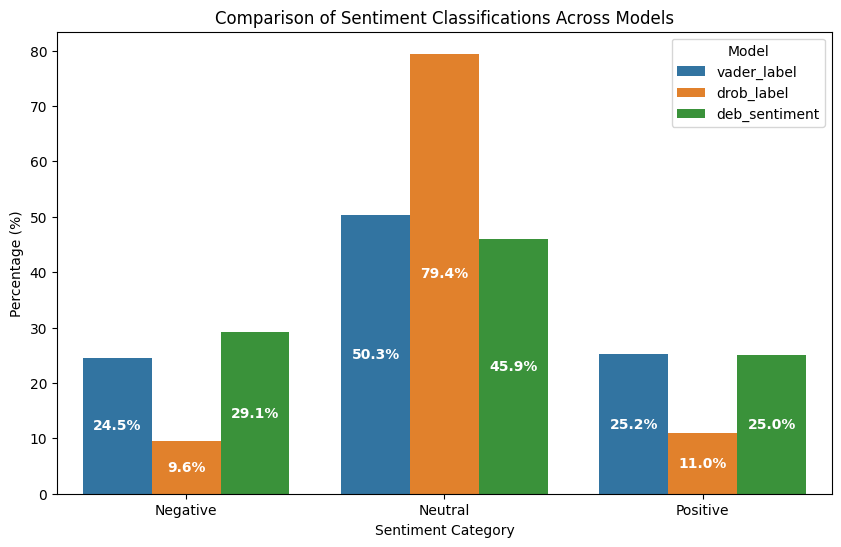

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_sentiment_models(df, model_columns):
   
    # Count occurrences of each sentiment per model
    sentiment_counts = {}
    for model in model_columns:
        sentiment_counts[model] = df[model].value_counts(normalize=True) * 100  # Convert to percentage

    sentiment_df = pd.DataFrame(sentiment_counts).fillna(0)

    sentiment_df = sentiment_df.reset_index().rename(columns={"index": "Sentiment"})
    sentiment_df_melted = sentiment_df.melt(id_vars=["Sentiment"], var_name="Model", value_name="Percentage")

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Sentiment", y="Percentage", hue="Model", data=sentiment_df_melted)

    # Annotate bars with percentages
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only annotate bars with non-zero values
            ax.annotate(f"{height:.1f}%", 
                        (p.get_x() + p.get_width() / 2., height / 2),  # Position text in the middle of the bar
                        ha='center', va='center', fontsize=10, color='white', fontweight='bold')

    # Labels and title
    plt.xlabel("Sentiment Category")
    plt.ylabel("Percentage (%)")
    plt.title("Comparison of Sentiment Classifications Across Models")
    plt.legend(title="Model")

    # Display the plot
    plt.show()

compare_sentiment_models(sentiment_df, ["vader_label", "drob_label","deb_sentiment"])


#### Misc [UNUSED]

##### Transformer (RoBERTa Model - Twitter trained)
* Pretrained on twitter data, may not be as helpful for news

In [ ]:
# Predict
def rob_polarity_scores(sentence):
    encoded_text = tokenizer(sentence, return_tensors='tf')
    
    output = model(encoded_text)
    scores = output.logits[0].numpy()
    scores = tf.nn.softmax(scores).numpy()
    
    # scores_dict = {
    #     'rob_neg': scores[0],
    #     'rob_neu': scores[1],
    #     'rob_pos': scores[2]
    # }
    return scores[0], scores[1], scores[2]

sentiment_df[['rob_neg','rob_neu','rob_pos']] = sentiment_df['headline'].apply(rob_polarity_scores).apply(pd.Series)

# Add label based on largest (neg/neu/pos)
sentiment_df['rob_label'] = sentiment_df.apply(lambda x:'Negative' if x['rob_neg'] >
                     x['rob_neu'] and x['rob_neu'] > x['rob_pos'] else ('Neutral' if x['rob_neu']>x['rob_pos'] else 'Positive'),axis=1)

sentiment_df.head()

KeyboardInterrupt: 

C:\Users\Tammy\AppData\Local\Temp\ipykernel_10600\1459403775.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=custom_palette, order=sentiment_order)


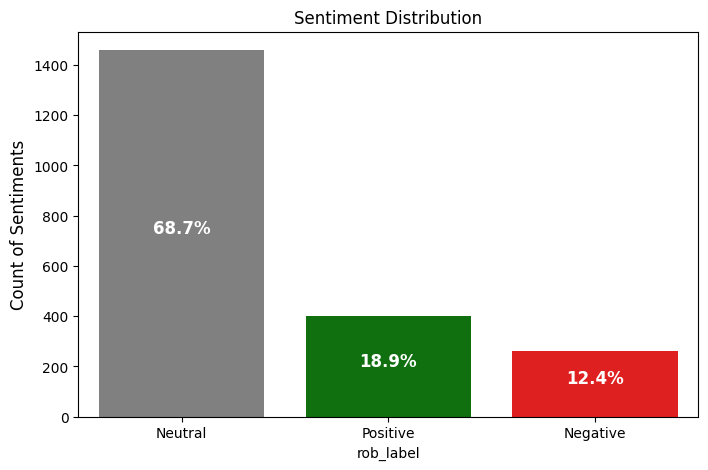

In [ ]:
sen_bar_plot(sentiment_df,'rob_label')

##### Transfomer (RoBERTa Model - News trained)

https://huggingface.co/rahilv/news-sentiment-analysis-roberta OR
https://huggingface.co/fhamborg/roberta-targeted-sentiment-classification-newsarticles 

In [ ]:
# from transformers import AutoTokenizer
# from transformers import TFAutoModelForSequenceClassification
# from scipy.special import softmax

#Load the pre-trained model
MODEL = f"rahilv/news-sentiment-analysis-roberta"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

In [ ]:
# sentiment_df.to_csv('headline_sent.csv')

##### Transformer

In [ ]:
# ! pip install tensorflow
# ! pip install transformers
# ! conda update tensorflow keras


In [ ]:
# testing
from transformers import pipeline
import tensorflow as tf
classifier = pipeline("sentiment-analysis")
print(classifier("Apple's stock is performing great!"))


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


[{'label': 'POSITIVE', 'score': 0.9998513460159302}]


In [ ]:
# Extract labels and scores into separate columns
sentiment_df['headline_label'] = sentiment_df['headline'].apply(lambda x: classifier(x)[0]['label'])
sentiment_df['headline_score'] = sentiment_df['headline'].apply(lambda x: classifier(x)[0]['score'])

sentiment_df['abstract_label'] = sentiment_df['abstract'].apply(lambda x: classifier(x)[0]['label'])
sentiment_df['abstract_score'] = sentiment_df['abstract'].apply(lambda x: classifier(x)[0]['score'])


def classify_sentiment(row):
    # If both labels are the same, use that label
    if row['headline_label'] == row['abstract_label']:
        return row['headline_label']
    # If scores are different, take the one with the higher score
    elif row['headline_score'] < row['abstract_score']:
        return row['abstract_label']
    else:
        return row['headline_label']


sentiment_df['transf_sent'] = sentiment_df.apply(classify_sentiment, axis=1)


sentiment_df # will take a while 

,pub_date,abstract,lead_para,headline,doc_type,section_name,type_of_material,rank,web_url,NLTK_sentiment,sentiment_label,vader_sent,headline_label,headline_score,abstract_label,abstract_score,transf_sent
0,2015-01-30,"James B. Stewart, on CNBC, discusses why Apple became twice as big as Microsoft. One reason: Apple’s willingness to “destroy” its own products in the interest of innovation.","James B. Stewart, on CNBC, discusses why Apple became twice as big as Microsoft. One reason: Apple’s willingness to “destroy” its own products in the interest of innovation.",Apple’s Near-Death Experience Saved It,multimedia,Business Day,Video,1,https://www.nytimes.com/video/business/100000003482723/apples-near-death-experience-saved-it.html,0.59660,Positive,0.59660,POSITIVE,0.997434,NEGATIVE,0.979103,POSITIVE
1,2015-01-14,"You probably didn’t know about these five features hidden in the iPhone’s iOS 8 operating system. Use them, and you’ll be using your phone like a pro.","You probably didn’t know about these five features hidden in the iPhone’s iOS 8 operating system. Use them, and you’ll be using your phone like a pro.",Use the iPhone’s iOS 8 Like a Pro,multimedia,Technology,Video,5,https://www.nytimes.com/video/technology/personaltech/100000003448481/use-the-iphones-ios8-like-a-pro.html,0.36120,Positive,0.36120,NEGATIVE,0.728277,NEGATIVE,0.997372,NEGATIVE
2,2015-03-10,"The Apple Watch is good looking for a smartwatch and not hard to use, according to initial impressions. But who knows if it is really a necessary purchase.","SAN FRANCISCO — When Apple unveiled its watch last fall, the company showed only demo models of the new device — polished prototypes of the hardware running nonworking loops of the software.","Apple Watch Displays Your Digital World, at a Glance",article,Technology,News,5,https://www.nytimes.com/2015/03/10/technology/personaltech/apple-watch-displays-your-digital-world-at-a-glance.html,0.18555,Positive,0.18555,POSITIVE,0.972429,POSITIVE,0.989358,POSITIVE
3,2015-03-06,Third-party apps and recent operating system updates are often the cause; starting the phone in Safe Mode can help narrow down the search for a culprit.,Q. My Android phone just started freezing and crashing a few days ago. What would cause it to do so?,Troubleshooting Android in Safe Mode,article,Technology,Question,3,https://www.nytimes.com/2015/03/06/technology/personaltech/troubleshooting-android-in-safe-mode.html,0.61910,Positive,0.61910,NEGATIVE,0.993856,NEGATIVE,0.996871,NEGATIVE
4,2015-03-18,"Here are some prominent services offering live TV, à la carte networks and other on-demand streaming options in the United States.","Here are some prominent services offering live TV, à la carte networks and other on-demand streaming options in the United States.","Suddenly, Plenty of Options for Cord Cutters",multimedia,Business Day,Interactive Feature,3,https://www.nytimes.com/interactive/2015/business/media/streaming-tv-cord-cutting-guide.html,0.31245,Positive,0.31245,NEGATIVE,0.954004,POSITIVE,0.971168,POSITIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,2024-12-07,Smartphone apps downloaded from Apple and Google can allow parents and other abusers to connect with pedophiles who pay to watch — and direct — criminal behavior.,"The promotional photo showed a mother affectionately hugging and kissing her daughter. The girl, around 8 years old, smiled into the camera.","On These Apps, the Dark Promise of Mothers Sexually Abusing Children",article,U.S.,News,8,https://www.nytimes.com/2024/12/07/us/child-abuse-apple-google-apps.html,-0.46790,Negative,-0.46790,POSITIVE,0.690404,NEGATIVE,0.982468,NEGATIVE
2139,2024-07-31,"Since 2022, Tripp Mickle has covered news surrounding one of the biggest technology companies in Silicon Valley.","Some journalists have broad beats — animals, the entire state of California, even the cosmos.",The Apple of One Business Reporter’s Eye,article,Times Insider,News,2,https://www.nytimes.com/2024/07/31

In [ ]:
# visualising sentiment score over time for 2024 (weekly agg)
from datetime import date

date_start = date(2024, 1, 1)

vader_sent = sentiment_df[['pub_date','vader_sent']]
vader_sent = vader_sent[vader_sent['pub_date'] > date_start]
vader_sent['month_idx'] = vader_sent['pub_date'].apply(lambda x: x.strftime('%Y-%U')) # Use U instead of M for month

vader_time_sent = vader_sent.groupby(by='month_idx', as_index=False)['vader_sent'].mean()

# vader_time_sent["month_idx"] = vader_time_sent["pub_date"].apply(lambda x: x.strftime("%Y-%U"))
# vader_time_sent
vader_time_sent.head()

,month_idx,vader_sent
0,2024-00,0.000000
1,2024-01,0.385650
2,2024-02,0.059960
3,2024-03,0.127380
4,2024-04,0.112343


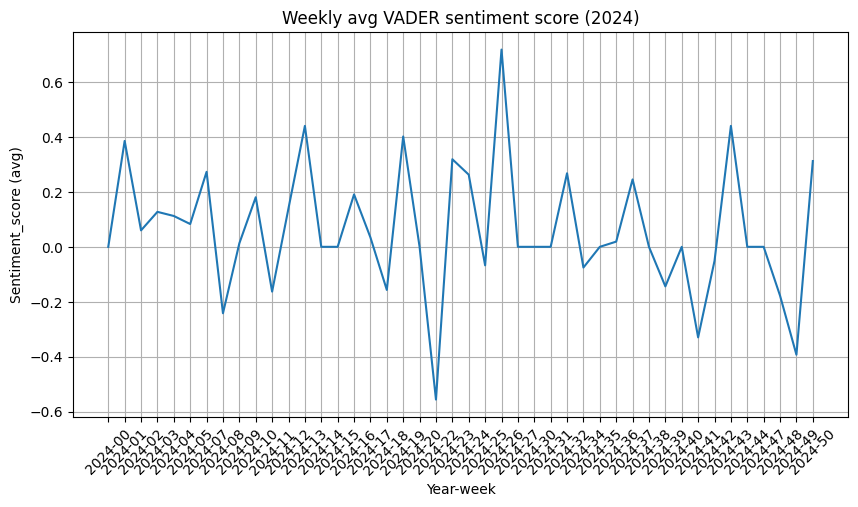

In [ ]:
# visualise sentiment score over the years
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=vader_time_sent, x='month_idx', y='vader_sent')

plt.xlabel('Year-week')
plt.ylabel('Sentiment_score (avg)')
plt.title('Weekly avg VADER sentiment score (2024)')
plt.xticks(rotation=45)

plt.grid(True)
plt.show()


In [ ]:
sentiment_df.vader_label.value_counts()

vader_label
Neutral     1068
Positive     535
Negative     521
Name: count, dtype: int64